# 对于多标签多分类问题

## 单标签多分类算法原理



1、单标签多分类问题其实是指待预测的label标签只有一个，但是 label标签的取值可能有多种情况；直白来讲就是每个实例的可能
   类别有K种(t1,t2,...tk,k≥3)；
   
2、常见算法：Softmax、SVM、KNN、决策树（集成学习 ----RF（Bagging）、Boosting（Adaboost、GBDT）；XGBoost） 


## 单标签多分类算法原理-ovo

原理：将K个类别中的两两类别数据进行组合，然后使用组合后的 数据训练出来一个模型，从而产生K(K-1)/2个分类器，将这些分类
     器的结果进行融合，并将分类器的预测结果使用多数投票的方式 输出最终的预测结果值。

## 单标签多分类算法原理-ovr

ovr与softmax的区别：

    ① softmax 每一次训练模型用的是整个训练数据中的某一类别的数据，从而得到该类别的权重系数，通过测试集计算各个类型权
      重的预测值，取最大的预测值（或者概率）的类型作为预测类型。
      
    ② ovr 每一次是代入所有的训练集数据来训练子模型，取出结果为正例的类别（多个正例取最大值）。


## 多标签多分类

1、多标签多分类这类问题的解决方案可以分为两大类：

    1) 转换策略(Problem Transformation Methods)；
    
        • Binary Relevance(first-order)           --------- y标签之间相互独立
        • Classifier Chains(high-order)           --------- y标签之间相互依赖（链式）
        • Calibrated Label Ranking(second-order)  --------- 了解
        
    2) 算法适应(Algorithm Adaptation)。
        • ML-kNN 
        • ML-DT

## 多标签多分类的评价指标

In [ ]:
（1）Hamming loss（汉明损失） ：所有label中错误分类样本的比例，from sklearn.metrics import hamming_loss
（2）Jaccard index(杰卡德指数)：预测结果与真实值的相似程度；
（3）精确率、召回率、F1

# 数据准备

## 连接数据

In [24]:
import pyodbc
#connect odbc 
cnxn = pyodbc.connect("DSN=tdh")
cursor = cnxn.cursor()

## 获取钢轨+过重+伤损数据

In [25]:
import pandas as pd
dataInjury = pd.read_sql('''
select ann_gross_weight,weight_ratio,damage_m,laying_obs_time_dif,distance_weight,time_diff_weight,distance_degree,damage_degree 
from railway_sys.model_injury_scale_10_result_csv''' ,con=cnxn)
dataInjury.head()

,ann_gross_weight,weight_ratio,damage_m,laying_obs_time_dif,distance_weight,time_diff_weight,distance_degree,damage_degree
0,16.592,0.085,1,2953,0.001,0.0,0.0,0
1,16.592,0.085,1,2953,0.001,0.0,0.0,0
2,48.463,0.298,1,2393,0.001,0.0,0.0,0
3,48.463,0.119,1,1127,0.001,0.0,0.0,0
4,16.592,0.085,1,2953,0.001,0.0,0.0,0


## 伤损记录标签

### 伤损为1，没有为0

In [26]:
def setLabel(data):
    if data!=0:
        return 1
    else:
        return 0
  

In [27]:
  
dataInjury['label']= dataInjury.damage_degree.apply(setLabel)
dataInjury.head()

,ann_gross_weight,weight_ratio,damage_m,laying_obs_time_dif,distance_weight,time_diff_weight,distance_degree,damage_degree,label
0,16.592,0.085,1,2953,0.001,0.0,0.0,0,0
1,16.592,0.085,1,2953,0.001,0.0,0.0,0,0
2,48.463,0.298,1,2393,0.001,0.0,0.0,0,0
3,48.463,0.119,1,1127,0.001,0.0,0.0,0,0
4,16.592,0.085,1,2953,0.001,0.0,0.0,0,0


In [28]:
dataInjury['label'].value_counts()

0    878333
1      3032
Name: label, dtype: int64

In [43]:
dataset = dataInjury[['ann_gross_weight','weight_ratio','damage_m','laying_obs_time_dif','distance_weight','time_diff_weight','distance_degree','damage_degree','label']]

In [45]:
dataset.head()

,ann_gross_weight,weight_ratio,damage_m,laying_obs_time_dif,distance_weight,time_diff_weight,distance_degree,damage_degree,label
0,76.739,0.907,1,3744,0.001,351.000,15.789,0,0
1,89.190,1.007,1,4658,0.001,358.000,16.667,0,0
2,67.745,0.487,1,2496,0.001,0.000,0.000,0,0
3,89.190,1.007,1,4658,0.001,0.000,0.000,0,0
4,38.365,0.413,1,3532,0.001,218.007,70.714,0,0


### 对月份进行one-hot编码

In [44]:
def oneHot(data, colName):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    values = data[colName].values
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)
    for i in range(onehot_encoded.shape[1]):
        data['y_degree' + str(i)] = onehot_encoded[:, i]
    return data

In [45]:
X = dataset.iloc[:,:-1]
y =dataset.iloc[:,-1]

X =oneHot(X,'damage_m')

## 全部伤损类别下采样

In [46]:
# RandomUnderSampler函数是一种快速并十分简单的方式来平衡各个类别的数据: 随机选取数据的子集.
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X, y)
 
sorted(Counter(y_resampled).items())

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 3032), (1, 3032)]

In [64]:
cols=['ann_gross_weight','weight_ratio','damage_m','laying_obs_time_dif','distance_weight','time_diff_weight','distance_degree','damage_degree']

dataX = pd.DataFrame(data = X_resampled,columns=cols)
dataY = pd.DataFrame(data = y_resampled,columns=['label'])
dataY['degree'] = dataX.iloc[:,-1].apply(lambda x: str(x))
dataY = oneHot(dataY,'degree')
dataX = dataX.iloc[:,:-1]

#del dataY['degree']

In [48]:
dataY.head()

,label,degree,y_degree0,y_degree1,y_degree2,y_degree3,y_degree4
0,0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.0,1.0,0.0,0.0,0.0,0.0


In [49]:
import io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import get_data_home
from sklearn.externals.joblib import Memory
from sklearn.multioutput import ClassifierChain,MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
try:
    from urllib.request import urlopen
except ImportError:
    # Python 2
    from urllib2 import urlopen

print(__doc__)

Automatically created module for IPython interactive environment


# 样本切分

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size=.2,
                                                    random_state=10)

# OneVsRestClassifier

In [66]:
# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
#ovr = OneVsRestClassifier(LogisticRegression())
ovr = OneVsRestClassifier(DecisionTreeClassifier())
ovr.fit(X_train, Y_train.loc[:,'degree'])
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_similarity_score(Y_test.loc[:,'degree'], Y_pred_ovr)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


准确率
0.9439406430338005
分类器精确度，召回率，F1值等信息。
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       621
         1.0       0.50      1.00      0.67         1
         2.0       0.87      0.81      0.84       168
         3.0       0.94      0.92      0.93       420
         4.0       0.00      0.00      0.00         3

    accuracy                           0.94      1213
   macro avg       0.66      0.75      0.69      1213
weighted avg       0.96      0.94      0.95      1213



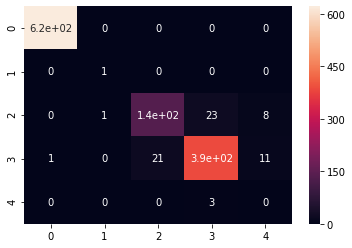

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('准确率')
print(accuracy_score(Y_test.loc[:,'degree'], Y_pred_ovr)) # 打印评估指标（分类准确率）
print('分类器精确度，召回率，F1值等信息。')
print(classification_report(Y_test.loc[:,'degree'], Y_pred_ovr)) 

conf = confusion_matrix(Y_test.loc[:,'degree'], Y_pred_ovr) # 混淆矩阵

label = ["0","1","2","3","4"] # 
sns.heatmap(conf, annot = True, xticklabels=label, yticklabels=label)

# 模型保存

In [62]:
def pmml_save(model, feat_list, save_file_path):
    '''
    ------------------
    功能：将训练完成的模型保存为pmml文件
    ------------------
    :param model: sklearn机器学习包实例化后训练完毕的模型
    :param feat_list: list, 最终入模的特征变量列表。
           若不指定feats_list, 那么写入的pmml中特征名默认取值为['x0', 'x1', ...]
    :param save_file_path: str, 保存模型文件的目标路径
    ------------------
    :return None
    ------------------
    '''
    from sklearn2pmml import sklearn2pmml, PMMLPipeline
    from sklearn_pandas import DataFrameMapper

    if not save_file_path.endswith('.pmml'):
        raise Exception('参数save_file_path后缀必须为pmml, 请检查！')
        
    mapper = DataFrameMapper([([i], None) for i in feat_list])
    pipeline = PMMLPipeline([('mapper', mapper), ("classifier", model)])
    sklearn2pmml(pipeline, pmml=save_file_path)
    
    print('模型文件已保存至{}'.format(save_file_path))

In [63]:
cols = ['ann_gross_weight','weight_ratio','damage_m','laying_obs_time_dif','distance_weight','time_diff_weight','distance_degree']
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Java/jdk1.8.0_211/bin'

pmml_save(ovr,cols,'model_PMML/ovrMultClassify.pmml')

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


模型文件已保存至model_PMML/ovrMultClassify.pmml


In [53]:
ovr_jaccard_score

0.9406430338004946

In [54]:
sorted(Counter(Y_pred_ovr).items())

[('0.0', 622), ('1.0', 2), ('2.0', 156), ('3.0', 410), ('4.0', 23)]

# Classifier Chains

In [68]:
col = list(Y_train.columns)
col.pop(col.index('degree'))
Y_train2 = Y_train[col]
Y_test2 = Y_test[col]

Classifier Chains方式的优点如下： 
    • 实现方式相对比较简单，容易理解； 
    • 考虑标签之间的依赖关系，最终模型的泛化能力相对于Binary Relevance方 式构建的模型效果要好。 
• 缺点如下： 
    • 很难找到一个比较适合的标签依赖关系。


In [69]:
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(DecisionTreeClassifier(), order='random', random_state=i)
          for i in range(6)]
for chain in chains:
    chain.fit(X_train, Y_train2)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_similarity_score(Y_test2, Y_pred_chain >= .5)
                        for Y_pred_chain in Y_pred_chains]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_similarity_score(Y_test2,
                                                  Y_pred_ensemble >= .5)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# 还原预测标签

In [70]:
def getPreY(data,probability):
    import numpy as np
    y_pre = []
    for i in range(len(data)):
        temp=[]
        if data[i][0] > probability:
            temp.append(1)
        else:
             temp.append(0) 
        temp.append(data[i][1:].argmax())
        y_pre.append(temp)
    return y_pre

In [76]:
y_pre = getPreY(Y_pred_ensemble,0.5)
y1= pd.DataFrame(y_pre).iloc[:,0].value_counts()
y2= pd.DataFrame(y_pre).iloc[:,1].value_counts()
print(y1,y2)

0    622
1    591
Name: 0, dtype: int64 0    622
3    411
2    176
4      2
1      2
Name: 1, dtype: int64


In [93]:
Y_test.loc[:,'degree'].apply(lambda x:int(float(x)))

3224    3
2671    0
3283    3
4580    2
3304    3
4934    3
5942    3
502     0
4639    3
5439    3
1208    0
2636    0
5386    2
1067    0
6057    2
3012    0
1852    0
5204    2
1806    0
413     0
3117    3
3343    2
5301    3
4633    3
1259    0
1957    0
181     0
1668    0
4085    2
5456    2
       ..
5059    3
2537    0
2153    0
4531    2
5442    3
5891    3
645     0
3214    3
3816    3
2283    0
4550    3
3132    3
5992    3
2891    0
5908    3
3726    2
2108    0
5668    3
1841    0
132     0
3472    3
4879    3
1935    0
1661    0
4127    3
3264    3
1523    0
1144    0
176     0
2925    0
Name: degree, Length: 1213, dtype: int64

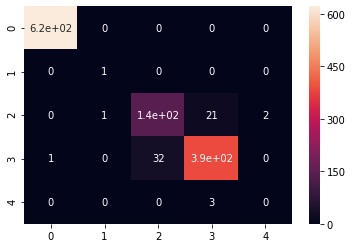

In [96]:
y_pre = pd.DataFrame(y_pre,columns=['label','degree']).applymap(str)
from sklearn.metrics import confusion_matrix
mul_scores = confusion_matrix(Y_test.loc[:,'degree'].apply(lambda x:int(float(x))), y_pre.loc[:,'degree'].apply(lambda x:int(float(x)))) # 混淆矩阵
label = ["0","1","2","3","4"] # 
sns.heatmap(mul_scores, annot = True, xticklabels=label, yticklabels=label)

# 模型效果展示

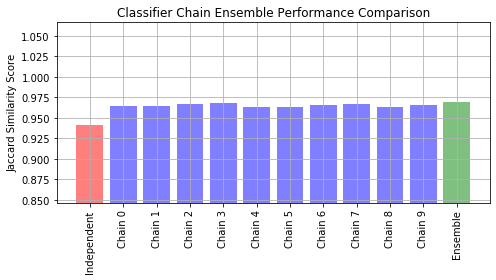

In [60]:
model_names = ['Independent']+['Chain '+str(i) for i in range(len(model_scores)-2)]+ ['Ensemble']

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [61]:
model_scores

[0.9406430338004946,
 0.9637262984336357,
 0.9640697993954381,
 0.966199505358615,
 0.9683979115141523,
 0.9625583951635064,
 0.9634514976641935,
 0.9655812036273702,
 0.9670239076669415,
 0.9629018961253092,
 0.9653751030502885,
 0.9693597142071999]

# Binary Relevance

Binary Relevance方式的优点如下： 
    • 实现方式简单，容易理解； 
    • 当y值之间不存在相关的依赖关系的时候，模型的效果不错。 
• 缺点如下： 
    • 如果y直接存在相互的依赖关系，那么最终构建的模型的泛化能力比较 弱； 
    • 需要构建q个二分类器，q为待预测的y值数量，当q比较大的时候，需 要构建的模型会比较多


In [21]:
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
br= MultiOutputClassifier(DecisionTreeClassifier())
br.fit(X_train, Y_train)

Y_pred_br = br.predict(X_test)
br_jaccard_scores =jaccard_similarity_score(Y_test, Y_pred_br >= .5)

br_scores = [ovr_jaccard_score]
br_scores.append(br_jaccard_scores)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [22]:
br_scores

[0.9650316020884859, 0.9640010992030777]

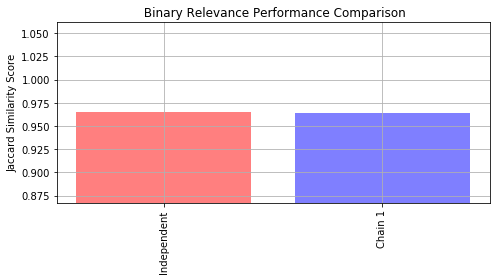

In [23]:
model_names = ('Independent',
               'Chain 1')

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title(' Binary Relevance Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(br_scores) * .9, max(br_scores) * 1.1])
colors = ['r'] + ['b']
ax.bar(x_pos, br_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()